## Importing libraries

In [5]:
%load_ext autoreload
%autoreload

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Reshape,Flatten,UpSampling2D,concatenate, Activation

import numpy as np
import matplotlib.pyplot as plt

from constants import INPUT_SHAPE, class2label
from conversion import get_class2color, FloorplanRaw, FloorplanSVG, read_room2class_condensed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from lxml import etree
import pdb
import re
from xml.dom import minidom
import numpy as np
import pdb
from skimage.draw import polygon
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from skimage import measure
import scipy
from scipy import ndimage

from lxml import etree
import imagesize

## Problem Definition

Our goal for this project is to study how well models with different and simpler model structure such as the ‘U-net’ model performs in comparison to the multi-task model used in paper in predicting wall positions and room types. We also plan to explore how knowing the positions of walls might help training models predicting room labels.

After reading through the paper, we find that the paper already did a good job in predicting room structures and labels accurately using a pipelined multi-task model. Nevertheless it used multi-task CNN to do many tasks such as predicting walls’ positions and room types separately. Thus, on the one side, we want to explore if other single-task models could produce a similar result; on the other hand, we identify that these two tasks can be related because knowing where the walls should provide information about the rooms which help predicting room types accurately. Following this intuition, we also decide to build a model taking both raw images and images indicating wall positions as input to predict room labels and see how that works out. More specifically, we added a weighted loss function that utilizes the extra information.



## Data exploration

As a detailed report of EDA is already written in milestone 2, so we are only including an introduction of features of the dataset that relate to our work most here. 

In [35]:
from os import walk

# Parse image directories
datadir = "./cubicasa5k/"
categories = ["colorful", "high_quality", "high_quality_architectural"]
image_dirs = {cat: None for cat in categories} # list of dir names in each category
for cat in categories:
    path = datadir + cat
    for _, dirnames, _ in walk(path):
        image_dirs[cat] = dirnames
        break

In [36]:
print("Number of floor plans in each category:")
for cat in categories:
    print(f"{cat}: {len(image_dirs[cat])}")

Number of floor plans in each category:
colorful: 276
high_quality: 992
high_quality_architectural: 3732


#### A showcase of sample images

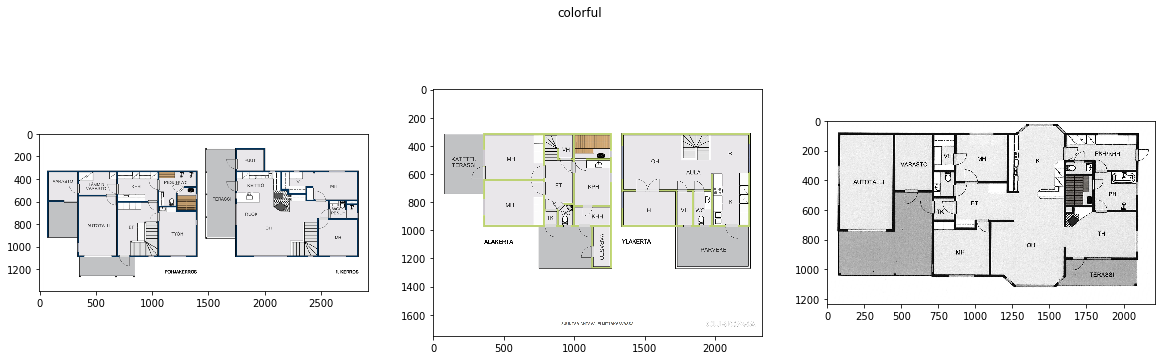

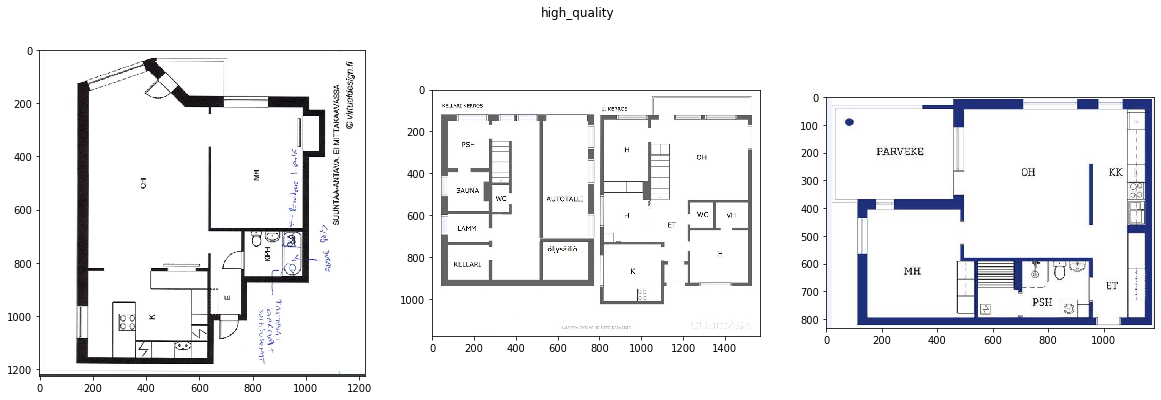

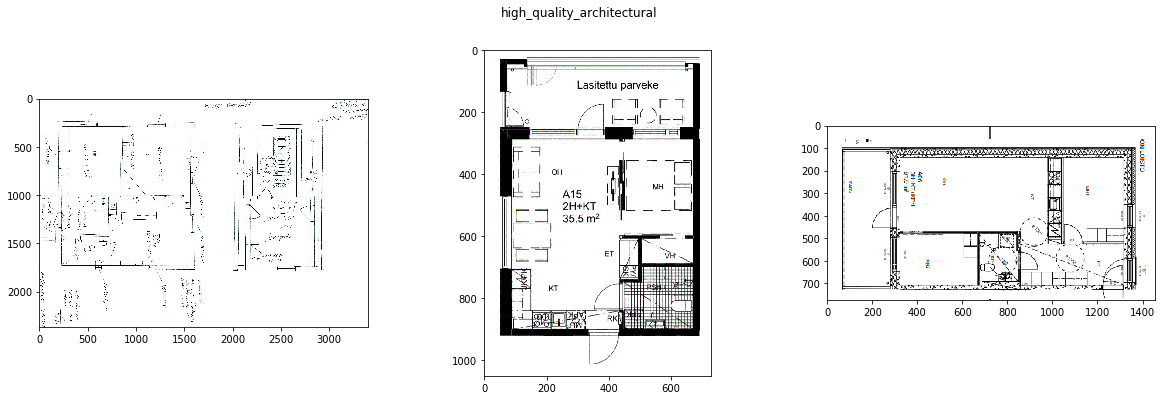

In [37]:
for cat in categories:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    fig.suptitle(cat)
    choices = np.random.choice(image_dirs[cat], size=3)
    for i, choice in enumerate(choices):
        fpath = datadir + cat + "/" + choice + "/F1_scaled.png"
        axes[i].imshow(plt.imread(fpath))

## Data Processing

As we need to extract ground truths from svg files, we need some helper functions as listed here. The main one we use is `extract_wall`. When we apply it to a data path, it will read the image and return a tuple, and the first part is the scaled raw image and the second part is a 256\*256 numpy array of zero's and one's where the one's indicate the position of walls.

In [2]:
class Wall:
    def __init__(self, id, end_points, direction, width, name):
        self.id = id
        self.name = name
        self.end_points = end_points
        self.direction = direction
        self.max_width = width
        self.min_width = width

    def change_end_points(self):
        if self.direction == 'V':
            self.end_points[0][0] = np.mean(np.array(self.min_coord))
            self.end_points[1][0] = self.end_points[0][0]
        elif self.direction == 'H':
            self.end_points[0][1] = np.mean(np.array(self.min_coord))
            self.end_points[1][1] = self.end_points[0][1]

    def get_length(self, end_points):
        return calc_distance(end_points[0], end_points[1])
class PolygonWall(Wall):
    def __init__(self, e, id, shape=None):
        self.id = id
        self.name = e.getAttribute('id')
        self.X, self.Y = self.get_points(e)
        if abs(max(self.X)-min(self.X)) < 4 or abs(max(self.Y)-min(self.Y)) < 4:
            # wall is too small and we ignore it.
            raise ValueError("small wall")
        if shape:
            self.X = np.clip(self.X, 0, shape[1])
            self.Y = np.clip(self.Y, 0, shape[0])
        # self.X, self.Y = self.sort_X_Y(self.X, self.Y)
        self.rr, self.cc = polygon(self.Y, self.X)
        #direction = self.get_direction(self.X, self.Y)
        #end_points = self.get_end_points(self.X, self.Y, direction)
        #self.min_width = self.get_width(self.X, self.Y, direction)
        #self.max_width = self.min_width

        #Wall.__init__(self, id, end_points, direction, self.max_width, self.name)
        #self.length = self.get_length(self.end_points)
        #self.center = self.get_center(self.X, self.Y)
        #self.min_coord, self.max_coord = self.get_width_coods(self.X, self.Y)

    def get_points(self, e):
        pol = next(p for p in e.childNodes if p.nodeName == "polygon")
        points = pol.getAttribute("points").split(' ')
        points = points[:-1]

        X, Y = np.array([]), np.array([])
        for a in points:
            x, y = a.split(',')
            X = np.append(X, np.round(float(x)))
            Y = np.append(Y, np.round(float(y)))

        return X, Y

def clip_outside( rr, cc,shape):
        s = np.column_stack((rr, cc))
        s = s[s[:, 0] < shape[0]]
        s = s[s[:, 1] < shape[1]]

        return s[:, 0], s[:, 1]
def extract_wall(data_path):
    fplan=cv2.imread(data_path+'F1_scaled.png')
    fplan=cv2.cvtColor(fplan,cv2.COLOR_BGR2RGB)
    height,width,nchannel=fplan.shape
    #fplan=np.moveaxis(fplan,-1,0)
    svg=minidom.parse(data_path+'model.svg')
    walls=np.zeros((height,width),dtype=np.uint8)
    wall_id=0
    shape=height,width
    for e in svg.getElementsByTagName('g'):
        try:
            if e.getAttribute("id")=="Wall":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 1
                wall_id+=1
                #plt.imshow(walls)
                #plt.show()
            if e.getAttribute("id")=="Railing":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 0.1
                wall_id+=1
        except ValueError as k:
            if str(k)=='small wall':
                continue
    input_image=cv2.resize(fplan,(256,256))
    wall_target=cv2.resize(walls,(256,256))
    return input_image,wall_target
    

## Wall Prediction

## Room Type Prediction

Our room type prediction model takes in a floorplan image and produces a semantic map where each pixel is assigned a class indicating its room type or being not a room.

We group the room types into 7 major categories:

In [9]:
# Mappings between room type, class label, and color for visualization
room2class = read_room2class_condensed("room_types_succinct.txt")
class2room = {v: k for k, v in room2class.items()}
class2color = get_class2color(max(room2class.values())+1)
n_classes = max(room2class.values())+1

print(list(class2label.values()))

['Empty', 'Entry', 'Outdoor', 'Bathroom', 'Kitchen', 'Livingroom', 'Bedroom', 'Others']


The input image is the same as in the model for wall prediction, while we extract the room type target semantic map from the `svg` file as a preprocessing step. The pipeline for this is as follows:

1. Create a blank 2D array of the same shape as the input image (256 x 256), which we refer to as the semantic map.
2. Read the polygon shapes of each room from the svg file.
3. Fill the pixels in the semantic map with the class labels of each polygon.
4. Apply `to_categorical` to the semantic map to expand it into a 3D array for classification training.


The semantic map of an example floor plan is shown below, overlayed on the input image.

In [10]:
# Load data
dataset_dir = "./data/cubicasa5k"

train_X = np.load(dataset_dir + "/train_inputs.npy")
train_y = np.load(dataset_dir + "/train_labels.npy")
train_y = to_categorical(train_y, num_classes=n_classes, dtype=np.int8)
val_X = np.load(dataset_dir + "/val_inputs.npy")
val_y = np.load(dataset_dir + "/val_labels.npy")
val_y = to_categorical(val_y, num_classes=n_classes, dtype=np.int8)

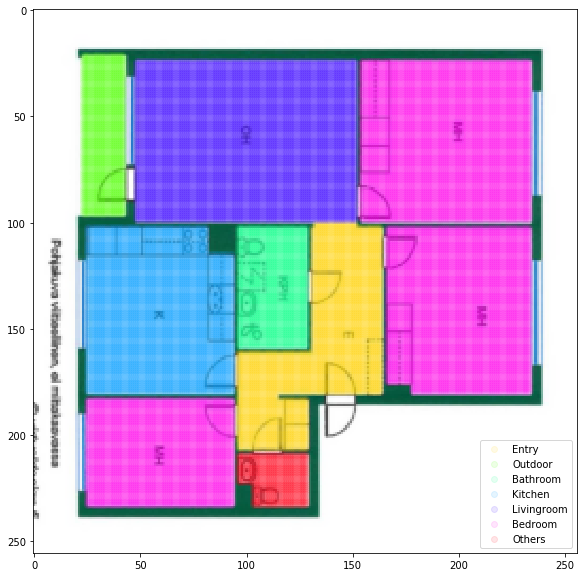

In [12]:
idx = 5
input_example = val_X[idx]
label_example = val_y[idx]
FloorplanSVG.show_map(np.argmax(label_example, axis=-1), input_example, class2color, class2room)

The neural network model is very similar to the one for the wall prediction (U-net) except for the linear activation for the 2nd-to-last layer, and that last layer produces an array with n_classes channels.

In [16]:
# Neural network model for room type prediction
input_layer = Input(shape=INPUT_SHAPE)

#encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

#decoder
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='linear', padding='same')(conv5)


out = Conv2D(n_classes, (1, 1) , padding='same', activation=tf.nn.softmax)(conv5)


model = Model(input_layer ,out, name = 'U-net')

loss = tf.keras.losses.categorical_crossentropy
opt = Adam(lr = 0.001)
model.compile(loss= loss, optimizer=opt, metrics = ['accuracy'])
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 256, 256, 32) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 32) 9248        dropout_5[0][0]                  
______________________________________________________________________________________________

In [17]:
model.load_weights("room_type_model_weights.h5")

After training for ~70 epochs, we achieved an accuracy of ~0.63 on the validation set. 

The output for the above example input is shown below:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


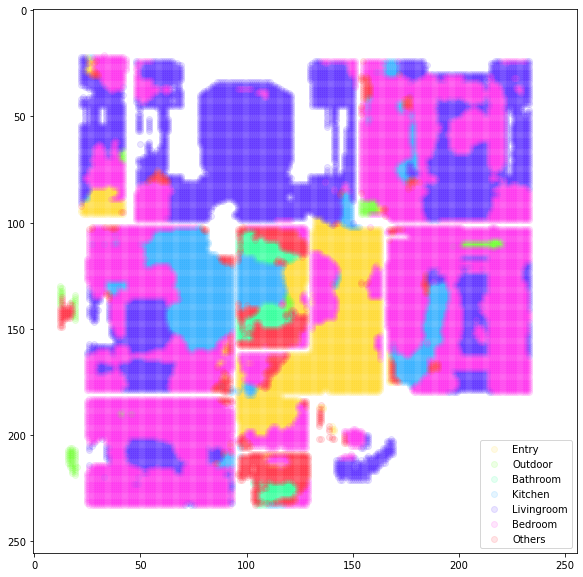

In [18]:
trial = val_X[idx]
result = model.predict(np.expand_dims(trial, axis=0))[0]
FloorplanSVG.show_map(np.argmax(result, axis=-1), 255*np.ones_like(trial), class2color, class2room)

The above result shows that the overall floor plan structures have been recovered and the room types have been identified yet they are sometimes inconsistent within each room, which brings us to the next section.

## Innovation - Room Type Consistency

As we can see in the previous part, when we predict the room type for every pixel of the graph, we are not utilizing the information that pixels close to each others should usually have the same label (if they are in the same room). Thus, in this section, we want to explore how knowing the positions of walls can help predict room types. 

Here we present an example of a wall image where we know the wall positions. The scaled image is shown besides too.

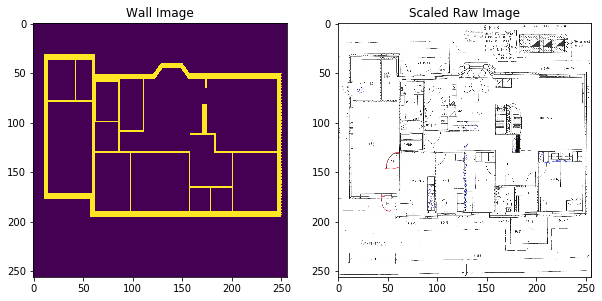

In [15]:
train_path='./cubicasa5k/train.txt' 
data_path=['./cubicasa5k'+i for i in np.genfromtxt(train_path,dtype='str')]
test=data_path[10]
x=extract_wall(test)
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(x[1])
plt.title('Wall Image')
plt.subplot(1,2,2)
plt.imshow(x[0])
_ = plt.title('Scaled Raw Image')

Then we use image processing tools to extract the room positions by flip the wall images. Notice that we also dilate the walls before we do the flip so that the new mask is slightly smaller than the actual spaces. This step is performed because we don't want to have our mask cover the walls, which is not our main concern in predicting room types correctly. We then also set the parts outside walls to zeros. This part is not performed very strictly. We also label these room chunks for future use.

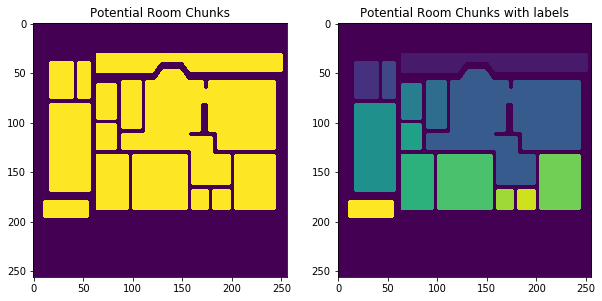

In [19]:
mask = ndimage.binary_dilation(x[1]).astype(np.float32)
mask = np.ones((256,256)) - mask

mask1 = mask.copy()
row = np.any(mask1==0,axis = 1)==1
col = np.any(mask1==0,axis = 0)==1
row1 = np.array([row]*256).transpose().astype(np.int8)
col1 = np.array([col]*256).astype(np.int8)
mask1 = np.floor((row1+col1)/2)

mask2 = np.floor((mask + mask1)/2)
mask2 = ndimage.binary_erosion(mask2).astype(np.float32)
mask2 = ndimage.binary_dilation(mask2).astype(np.float32)

mask2_3d = np.array([mask2]*3)
mask2_3d = mask2_3d.transpose((1, 2, 0))

plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(mask2)
plt.title('Potential Room Chunks')
plt.subplot(1,2,2)
labels = measure.label(mask2)
plt.imshow(labels)
_ = plt.title('Potential Room Chunks with labels')

Then we used this method to create numpy arrays saving these masks, using the code below.

In [ ]:
data_path = data_path1
Y=np.empty((len(data_path),256,256))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    x=extract_wall(data_path[i])
    
    mask = ndimage.binary_dilation(x[1]).astype(np.float32)
    mask = np.ones((256,256)) - mask

    mask1 = mask.copy()
    row = np.any(mask1==0,axis = 1)==1
    col = np.any(mask1==0,axis = 0)==1
    row1 = np.array([row]*256).transpose().astype(np.int8)
    col1 = np.array([col]*256).astype(np.int8)
    mask1 = np.floor((row1+col1)/2)

    mask2 = np.floor((mask + mask1)/2)
    mask2 = ndimage.binary_erosion(mask2).astype(np.float32)
    mask2 = ndimage.binary_dilation(mask2).astype(np.float32)
    labels = measure.label(mask2)

    Y[i] = labels

    
outfile = './saved_arrays/train_label.npy'
np.save(outfile, Y)

Our plan for the next step is to add a loss function to our model that measures the difference between pixels that are close to each other. We have written the code that expresses our goal but haven't included it to the model we used in the previous part yet.

In [25]:
rand_out = np.random.randint(0,4,size = (256,256))
test = to_categorical(rand_out) #test is a made-up image that mimic the form of our output, it's of shape(256,256,num_classes)
mask = labels #This is the mask transfered into the model with inputs

In [33]:
#test = final output layer
#mask = input mask
#alpha = weight of added loss

back = np.argmax(test,axis = 2)
back_down = np.roll(back,1,axis = 0)
back_down[0,:] = 0
back_right = np.roll(back,1)
back_right[:,0] = 0
num_class = back.max()+1

out_mask = tf.constant(to_categorical(back * (mask>0),num_classes = num_class))
out_down_mask = tf.constant(to_categorical(back_down * (mask>0),num_classes = num_class))
out_right_mask = tf.constant(to_categorical(back_right * (mask>0),num_classes = num_class))

new_loss =  tf.keras.backend.categorical_crossentropy(out_mask,out_down_mask) + tf.keras.backend.categorical_crossentropy(out_mask,out_right_mask)

#model.add_loss(alpha *new_loss)
np.mean(new_loss)

#

11.486997

As shown here, we are basically adding a new layer that calculates the cross entropy for each pixel in the output graph with the pixels right below it and right next to it on right. We do so by shifting the output graph down by one pixel and then applying the mask on it, setting all values outside the mask to 0 as they are not our concern. We then calculate the pixel-wise cross-entropy of this graph and the original output that also has the mask applied. Now the pixels not of our concern will not affect our results as they are set to have the same labels of 0s. Then we want to add this loss to the model with an alpha as weighting parameter. 

This part needs to be further adjusted to ensure the correctness of data types before we place it into the model, and we also need to test different alpha values so that the new model could work. We haven't tested this part as training other models took almost all our time, but it would be interesting to see how this additional part might improve the model performance.


## Conclusion